In [1]:
from parse_data import get_data, get_modified_values, get_binary_values, make_data_scalar
from rnn import PredictTime
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)

df = get_data()

Using device:  cuda


In [2]:

def make_data(df, device):

    x_train, y_train = [], []
    prev = None

    for row in df:
        if prev is None:
            prev = row
        x_train.append(prev)
        y_train.append(row)
        prev = row
    print(x_train[0].size())
    return torch.stack(x_train).float().to(device),torch.stack(y_train).float().to(device)

make_data(get_binary_values(get_data()), device)



torch.Size([1])


(tensor([[1.],
         [1.],
         [0.],
         ...,
         [1.],
         [0.],
         [1.]], device='cuda:0'),
 tensor([[1.],
         [0.],
         [1.],
         ...,
         [0.],
         [1.],
         [1.]], device='cuda:0'))

In [3]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
from IPython.display import clear_output
import torch.nn as nn
import random

batch_size = 200
x_d, y_d = make_data_scalar(get_data(), device)

print(y_d.size(), x_d.size())

model = PredictTime(input_size=x_d[0].size()[0],
                    output_size=y_d[0].size()[0],
                    hidden_layers=5,
                    hidden_size=100, device=device).to(device)
optimizer = optim.Adam(model.parameters())

loss = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(x_d,y_d), batch_size=batch_size)
epochs = 5000
for e in range(epochs):
    model.train()
    #print(next(iter(loader)))
    model.clean_state()
    res = []
    
    
    if random.random() < e/epochs:
        model.teacher_forcing = False
    else:
        model.teacher_forcing = True
    
    for x, y in loader:
        
        if random.random() < 0.3:
            continue
        model.init_state()
        
        
        y_pred = model(x)
        l = loss(y_pred, y)
        res.append(l)
        #print(y_pred, y)
    
    
    l = res[0]
    for i in res[1:]:
        l += i
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    if e % 10 != 0:
        continue
    #clear_output(wait=True)
    sum_loss = 0
    #print(list(model.parameters())[-1])

    for x, y in loader:
        model.eval()
        with torch.no_grad():
            y_pred = model(x)
            sum_loss += np.sqrt(loss(y_pred, y).cpu())
    
    print("Epoch %d Loss %.4f" % (e, sum_loss))
    
    
#for d in df.values:

Max value:  1000
torch.Size([8152, 1]) torch.Size([8152, 1])
Epoch 0 Loss 16.7996
Epoch 10 Loss 14.9271
Epoch 20 Loss 14.8532
Epoch 30 Loss 14.8382
Epoch 40 Loss 14.8459
Epoch 50 Loss 14.8336
Epoch 60 Loss 14.8271
Epoch 70 Loss 14.7541
Epoch 80 Loss 14.6678
Epoch 90 Loss 14.6769
Epoch 100 Loss 14.6473
Epoch 110 Loss 14.6493
Epoch 120 Loss 14.6342
Epoch 130 Loss 14.6339
Epoch 140 Loss 14.6182
Epoch 150 Loss 14.6004
Epoch 160 Loss 14.5762
Epoch 170 Loss 14.5460
Epoch 180 Loss 14.4761
Epoch 190 Loss 14.3919
Epoch 200 Loss 14.2384
Epoch 210 Loss 14.2148
Epoch 220 Loss 14.1957
Epoch 230 Loss 14.1826
Epoch 240 Loss 14.1756
Epoch 250 Loss 14.1747
Epoch 260 Loss 14.1642
Epoch 270 Loss 14.1584
Epoch 280 Loss 14.1465
Epoch 290 Loss 14.1406
Epoch 300 Loss 14.1397
Epoch 310 Loss 14.1280
Epoch 320 Loss 14.1188
Epoch 330 Loss 14.1098
Epoch 340 Loss 14.0897
Epoch 350 Loss 14.1078
Epoch 360 Loss 14.0873
Epoch 370 Loss 14.0872
Epoch 380 Loss 14.0724
Epoch 390 Loss 14.0650
Epoch 400 Loss 14.0285
Epoch 4

tensor(0.4427)


/opt/conda/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/opt/conda/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


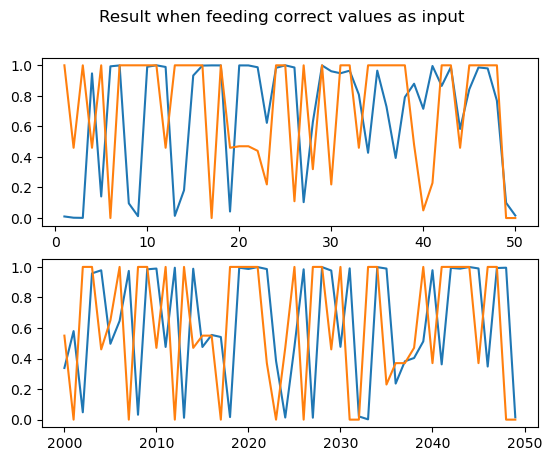

In [18]:
import matplotlib.pyplot as plt

def eval_model(x,y,m):
    df = get_data() 
    maxtime = df.max()[1]

    res = []
    m.eval()
    m.clean_state()
    count  = 1
    prev = x[0][0]
    for i in x:
        t = torch.tensor([[prev]]).to(device)
        prev = i
        val = m(t)
        count += 1
        res.append(val.detach().cpu()[0])
    
    loss = nn.MSELoss()
    print(np.sqrt(loss(torch.tensor(res).to(device),y.squeeze()).cpu()))
    

    fig, ax = plt.subplots(2)
    
    ax[0].plot(range(1,51), res[:50])
    ax[0].plot( range(1,51), y[:50].cpu())

    ax[1].plot(range(2000,2050), res[2000:2050])
    
    ax[1].plot(range(2000,2050), y[2000:2050].cpu() )
    fig.suptitle("Result when feeding correct values as input")
    fig.savefig("teacher_forcing.png")


amount = 1000
eval_model(x_d,y_d,model)


tensor(0.4717)


/opt/conda/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/opt/conda/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


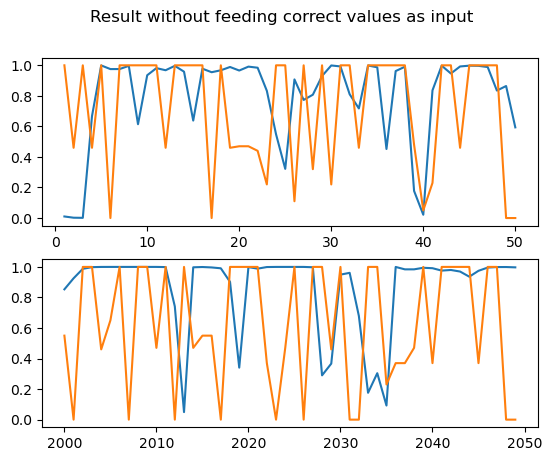

In [16]:
import matplotlib.pyplot as plt

def eval_model(x,y,m):
    df = get_data() 
    maxtime = df.max()[1]

    res = []
    m.eval()
    m.clean_state()
    count  = 1
    prev = x[0][0]
    for i in x:
        t = torch.tensor([[prev]]).to(device)
        prev = i
        val = m(t)
        prev = val
        count += 1
        res.append(val.detach().cpu()[0])
    
    loss = nn.MSELoss()
    print(np.sqrt(loss(torch.tensor(res).to(device),y.squeeze()).cpu()))
    
    fig, ax = plt.subplots(2)
    
    ax[0].plot(range(1,51), res[:50])
    ax[0].plot( range(1,51), y[:50].cpu())

    ax[1].plot(range(2000,2050), res[2000:2050])
    
    ax[1].plot(range(2000,2050), y[2000:2050].cpu() )
    fig.suptitle("Result without feeding correct values as input")
    fig.savefig("teacher_forcing_not_correct.png")
    
amount = 1000
eval_model(x_d,y_d,model)
